In [1]:
import tensorflow as tf
import os
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)
print(tf.config.list_physical_devices('GPU'))
import cv2
import imghdr
data_dir = 'signatures' 
image_exts = ['jpeg','jpg', 'bmp', 'png']
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)
data = tf.keras.utils.image_dataset_from_directory('signatures')
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Found 2640 files belonging to 2 classes.


In [2]:
import tensorflow as tf

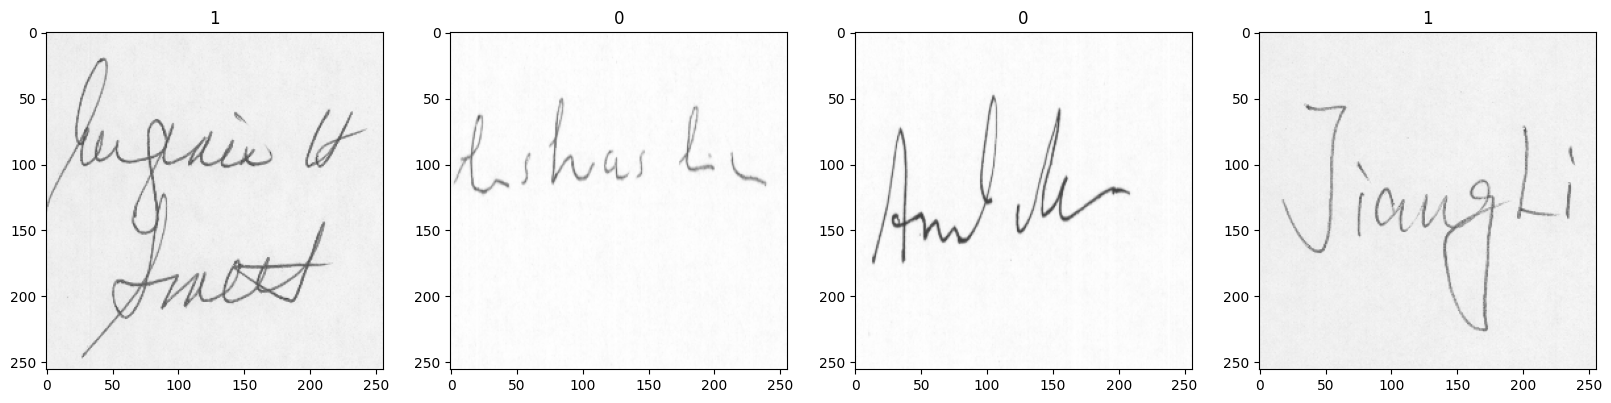

In [2]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [3]:
data = data.map(lambda x,y: (x/255, y))
data.as_numpy_iterator().next()
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)


In [4]:
train

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [5]:
model = Sequential()
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile('Ftrl', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

In [6]:
logdir='ftrl'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [7]:
hist = model.fit(train, epochs=100, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/100
58/58 [==============================] - 15s 97ms/step - loss: 0.6932 - accuracy: 0.5022 - val_loss: 0.6932 - val_accuracy: 0.4902
Epoch 2/100
58/58 [==============================] - 5s 78ms/step - loss: 0.6931 - accuracy: 0.5124 - val_loss: 0.6932 - val_accuracy: 0.4824
Epoch 3/100
58/58 [==============================] - 5s 78ms/step - loss: 0.6931 - accuracy: 0.5086 - val_loss: 0.6932 - val_accuracy: 0.4805
Epoch 4/100
58/58 [==============================] - 5s 78ms/step - loss: 0.6931 - accuracy: 0.5097 - val_loss: 0.6932 - val_accuracy: 0.4824
Epoch 5/100
58/58 [==============================] - 5s 79ms/step - loss: 0.6931 - accuracy: 0.5135 - val_loss: 0.6932 - val_accuracy: 0.4883
Epoch 6/100
58/58 [==============================] - 5s 78ms/step - loss: 0.6931 - accuracy: 0.5059 - val_loss: 0.6932 - val_accuracy: 0.4824
Epoch 7/100
58/58 [==============================] - 5s 79ms/step - loss: 0.6931 - accuracy: 0.5075 - val_loss: 0.6932 - val_accuracy: 0.4883
Epoch

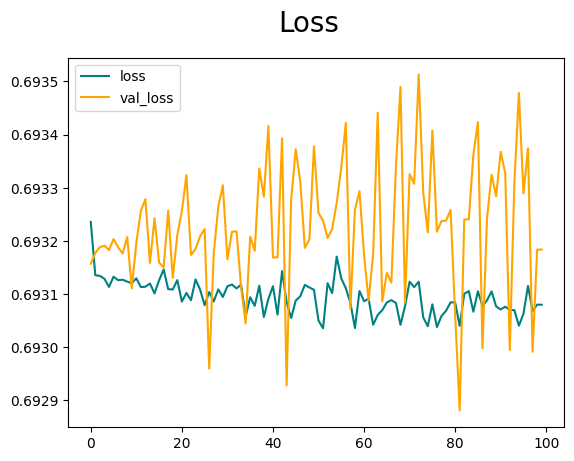

In [8]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

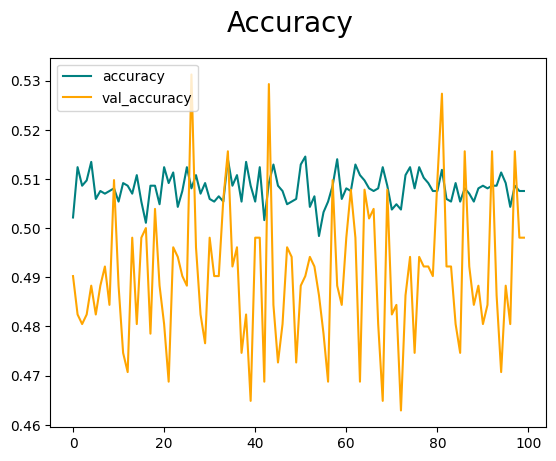

In [9]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [10]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
pre = Precision()
re = Recall()
acc = BinaryAccuracy()


In [11]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 24ms/step


In [12]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.4609375, shape=(), dtype=float32)


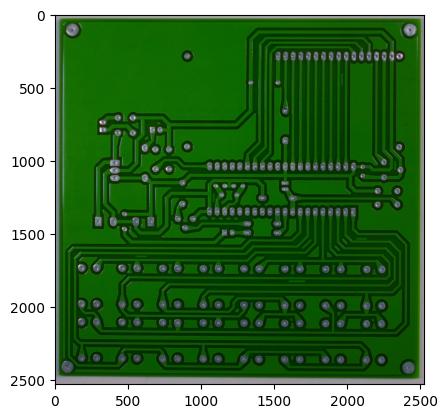

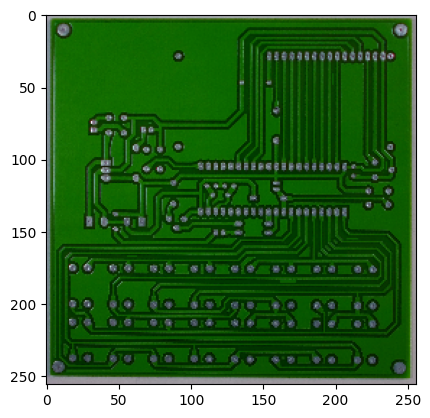

In [3]:
import cv2
import matplotlib.pyplot as plt
img = cv2.imread('12_spurious_copper_09.jpg')
plt.imshow(img)
plt.show()
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [14]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 184ms/step


In [15]:
yhat

array([[0.4972496]], dtype=float32)

In [16]:
if yhat > 0.5: 
    print(f'Predicted class is original')
else:
    print(f'Predicted class is forged')

Predicted class is forged


In [17]:
from tensorflow.keras.models import load_model
model.save(os.path.join('models','ftrl.h5'))

In [78]:

new_model = load_model('models/imageclassifier.h5')

In [79]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 46ms/step


array([[0.69642204]], dtype=float32)